# Traditional Financial Sector

(CHECK FOR SELF-LOOPS)

## Generating the graph

In [2]:
# Import packages
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pickle
from matplotlib import cm
from networkx.algorithms.community import greedy_modularity_communities
from collections import deque
import sys
import numpy as np
import networkx as nx
from matplotlib.pyplot import show, figure
from enum import Enum

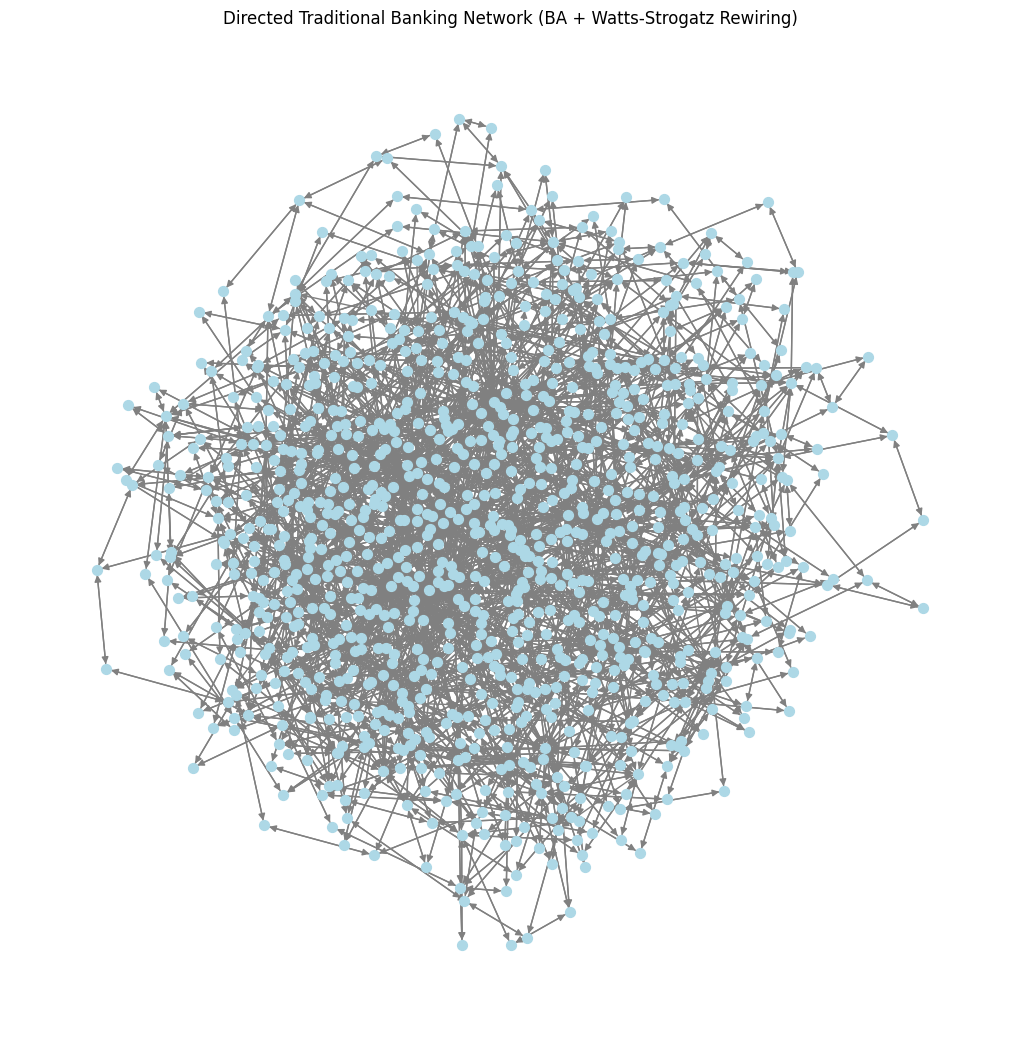

In [3]:
# Parameters for the traditional banking network
num_nodes = 1000 
num_connections_entry_banks = 2  # Each  bank on average connects to 8 existing banks (stronger centralization)
rewire_prob = 0.005  # Probability to rewire edges (lower for traditional banks)

# Step 1: Generate the Barabási-Albert graph (scale-free) and create a directed graph
graph_banks = nx.barabasi_albert_graph(num_nodes, num_connections_entry_banks)
graph_final_banks = nx.DiGraph()  # Directed graph to store final structure

# Step 2: Add nodes, weighted edges, and attributes to the directed graph
for node_id in range(num_nodes):
    neighbors = list(graph_banks.neighbors(node_id))  # Get neighbors of the node
    connected_node_ids = [nei for nei in neighbors]

    # Calculate edge weights
    num_connections = len(connected_node_ids)
    weights_val = 1 / num_connections if num_connections > 0 else 0  # Avoid division by zero
    weighted_edges = [(node_id, to_node_id, weights_val) for to_node_id in connected_node_ids]

    # Node attributes
    node_attrs = {
        'id': node_id,
        'defaulted_consecutive_turns' : 0,
        'all_connected_nodes': connected_node_ids
    }

    # Add the node and its attributes to the directed graph
    graph_final_banks.add_node(node_id, **node_attrs)
    # Add weighted directed edges to the directed graph
    graph_final_banks.add_weighted_edges_from(weighted_edges)

# Step 3: Rewire edges for clustering in the directed graph (Watts-Strogatz style)
for node_id in graph_final_banks.nodes():
    neighbors = list(graph_final_banks.successors(node_id))  # Get the successors (outgoing edges)
    
    # If the node has at least two neighbors, rewire edges between the successors
    if len(neighbors) >= 2:  # Ensure at least 2 neighbors for rewiring
        for i in range(len(neighbors)):
            for j in range(i + 1, len(neighbors)):
                # With a certain probability, create a directed edge between neighbors of the current node
                if random.random() < rewire_prob:
                    if not graph_final_banks.has_edge(neighbors[i], neighbors[j]):
                        # Add directed edge between two neighbors of node_id
                        graph_final_banks.add_edge(neighbors[i], neighbors[j], weight=1 / len(neighbors))

# Step 4: Visualize the directed graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(graph_final_banks, seed=42)  # Use spring layout for better visualization
nx.draw(graph_final_banks, pos, with_labels=False, node_size=50, node_color='lightblue', edge_color='gray', arrows=True)
plt.title("Directed Traditional Banking Network (BA + Watts-Strogatz Rewiring)")
plt.show()

In [4]:
average_degree = sum(dict(graph_final_banks.degree()).values()) / graph_final_banks.number_of_nodes()
print(f"Average degree: {average_degree}")

Average degree: 8.18


In [3]:
# Print node information
print("Node Information:")
for node, attributes in graph_final_banks.nodes(data=True):
    print(f"Node {node}: {attributes}")

# Print edges and their weights
print("\nEdge Information:")
for edge in graph_final_banks.edges(data=True):
    source, target, data = edge
    print(f"Edge from {source} to {target} with weight {data.get('weight', 'N/A')}")

Node Information:
Node 0: {'id': 0, 'total_defaulted_turns': 0, 'defaulted_consecutive_turns': 0, 'first_defaulted_at': -1, 'all_connected_nodes': [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 23, 27, 29, 31, 34, 36, 41, 54, 57, 62, 64, 74, 76, 87, 99]}
Node 1: {'id': 1, 'total_defaulted_turns': 0, 'defaulted_consecutive_turns': 0, 'first_defaulted_at': -1, 'all_connected_nodes': [0, 6, 7, 8, 13, 51]}
Node 2: {'id': 2, 'total_defaulted_turns': 0, 'defaulted_consecutive_turns': 0, 'first_defaulted_at': -1, 'all_connected_nodes': [0, 6, 7, 8, 9, 17, 31, 32, 34, 47, 48, 53, 54, 61, 63, 69, 77, 80, 85, 91, 96]}
Node 3: {'id': 3, 'total_defaulted_turns': 0, 'defaulted_consecutive_turns': 0, 'first_defaulted_at': -1, 'all_connected_nodes': [0, 6, 7, 12, 14, 19, 24, 25, 40, 46, 51, 52, 53, 62, 68, 91, 99]}
Node 4: {'id': 4, 'total_defaulted_turns': 0, 'defaulted_consecutive_turns': 0, 'first_defaulted_at': -1, 'all_connected_nodes': [0, 6, 7, 10, 18, 22, 31, 33, 39, 42, 50, 51, 57, 60, 83]}
Node 5

In [16]:
# Function to calculate characteristics of a graph
def graph_characteristics(G):
    characteristics = {}
    # Calculate Average clustering coefficient
    characteristics['average_clustering'] = nx.average_clustering(G)
    # Calculate Transitivity
    characteristics['transitivity'] = nx.transitivity(G)
    # Get the Degree Distribution
    degrees = [degree for node, degree in G.degree()]
    characteristics['degree_distribution'] = degrees
    
    # For the largest connected component
    if nx.is_connected(G):
        LCC = G  # If the graph is connected, no need to find LCC
    else:
        # Find the largest connected component
        largest_cc = max(nx.connected_components(G), key=len)
        LCC = G.subgraph(largest_cc).copy()
    
    # Calculate Average shortest path length (only for LCC)
    characteristics['average_shortest_path_length'] = nx.average_shortest_path_length(LCC)
    # Calculate Diameter (only for LCC)
    characteristics['diameter'] = nx.diameter(LCC)
    # Degree Centrality Distribution
    characteristics['degree_centrality'] = nx.degree_centrality(G)
    
    return characteristics

undirected_graph = graph_final_banks.to_undirected()
characteristics_graph = graph_characteristics(undirected_graph)

# Print out the results for comparison
print("Graph Characteristics :")
for k, v in characteristics_graph.items():
    if k != 'degree_distribution' and k != 'degree_centrality':
        print(f"{k}: {v}")




Graph Characteristics :
average_clustering: 0.048771722901200736
transitivity: 0.022010707911957167
average_shortest_path_length: 4.051137137137137
diameter: 7


Here we visualise and identify the hubs

Degree Centrality of Selected Hubs in Traditional Sector:
Hub Node 1: Centrality = 0.1221
Hub Node 0: Centrality = 0.1141
Hub Node 7: Centrality = 0.1051
Hub Node 26: Centrality = 0.0971
Hub Node 13: Centrality = 0.0931
Hub Node 4: Centrality = 0.0901
Hub Node 20: Centrality = 0.0741
Hub Node 6: Centrality = 0.0681
Hub Node 5: Centrality = 0.0641
Hub Node 11: Centrality = 0.0521
Hub Node 2: Centrality = 0.0460
Hub Node 18: Centrality = 0.0460
Hub Node 12: Centrality = 0.0440
Hub Node 69: Centrality = 0.0420
Hub Node 61: Centrality = 0.0400
Hub Node 28: Centrality = 0.0400
Hub Node 30: Centrality = 0.0380
Hub Node 48: Centrality = 0.0400
Hub Node 21: Centrality = 0.0380
Hub Node 19: Centrality = 0.0370
Hub Node 29: Centrality = 0.0350
Hub Node 10: Centrality = 0.0340
Hub Node 50: Centrality = 0.0360
Hub Node 31: Centrality = 0.0340
Hub Node 9: Centrality = 0.0330
Hub Node 16: Centrality = 0.0340
Hub Node 33: Centrality = 0.0340
Hub Node 153: Centrality = 0.0350
Hub Node 88: Centrality =

/var/folders/w1/fnwwrg7n2x1c0rysk11t1nmw0000gn/T/ipykernel_970/3249099359.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', 7)  # Colormap for up to 10 communities


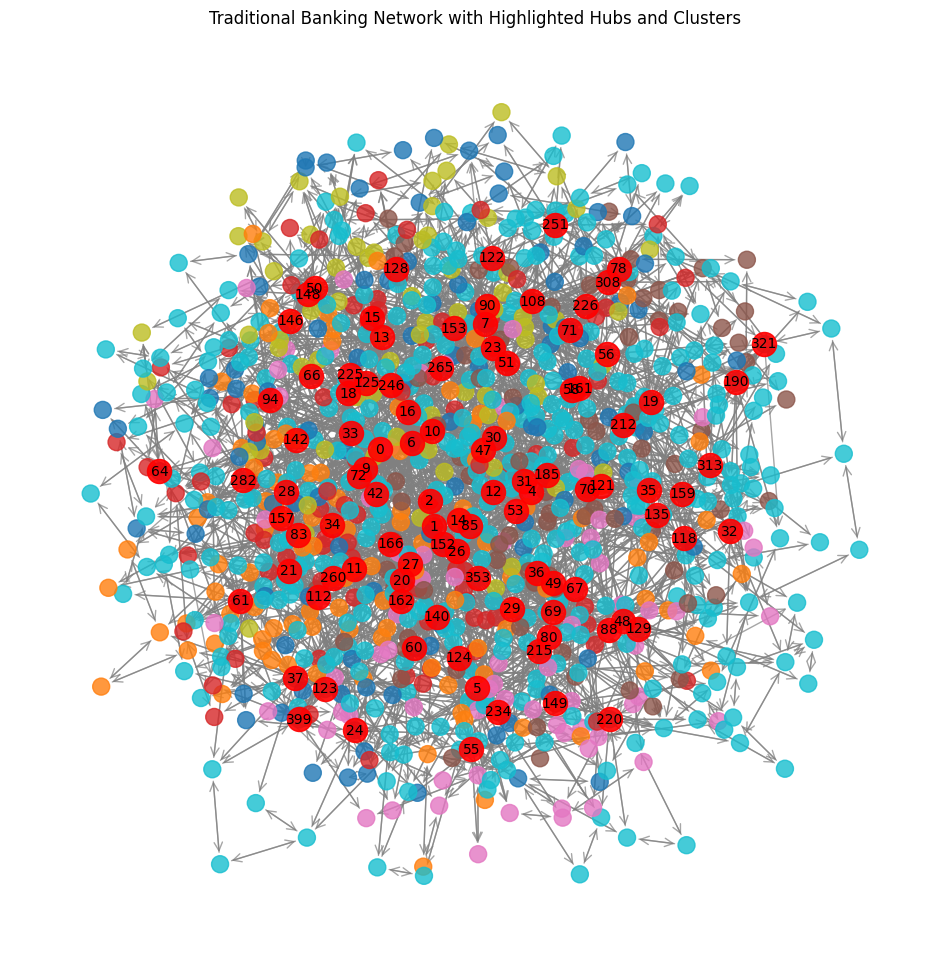

In [25]:
# Step 4: Identify Hubs (Nodes with the highest out-degree)
degree_dict = dict(graph_final_banks.out_degree())
num_hubs = int(0.1 * num_nodes)  # Take the top 5% as hubs
hubs = sorted(degree_dict, key=degree_dict.get, reverse=True)[:num_hubs]

# Step 5: Detect Communities (Clusters) using Greedy Modularity (Louvain-like)
communities = list(greedy_modularity_communities(graph_final_banks.to_undirected()))  # Work with undirected for clustering
community_map = {}
for i, community in enumerate(communities):
    for node in community:
        community_map[node] = i  # Assign each node to a cluster

# Step 5.5: Compute Degree Centrality for Hubs Only
# Calculate degree centrality for all nodes
degree_centrality = nx.degree_centrality(graph_final_banks)

# Filter centrality values for hubs only
hubs_centrality = {hub: degree_centrality[hub] for hub in hubs}

# Print top hubs with their degree centrality scores
print("Degree Centrality of Selected Hubs in Traditional Sector:")
for hub, centrality_value in hubs_centrality.items():
    print(f"Hub Node {hub}: Centrality = {centrality_value:.4f}")

# Step 6: Sample a Subgraph (e.g., 100 nodes) for visualization
sample_size = 1000
sampled_nodes = random.sample(list(graph_final_banks.nodes()), sample_size)
sampled_graph = graph_final_banks.subgraph(sampled_nodes)

# Filter hubs that are in the sampled graph
sampled_hubs = [hub for hub in hubs if hub in sampled_graph.nodes()]

# Step 7: Visualize the Sampled Directed Graph, Highlighting Hubs and Clusters
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(sampled_graph, seed=42)  # Spring layout for sampled graph

# Color nodes based on their community (cluster)
colors = cm.get_cmap('tab10', 7)  # Colormap for up to 10 communities
node_colors = [colors(community_map.get(node, 0)) for node in sampled_graph.nodes()]

# Draw all nodes, with hubs in larger size and different color
nx.draw_networkx_nodes(sampled_graph, pos, node_size=150, node_color=node_colors, alpha=0.8)

# Highlight hubs in red with larger size
nx.draw_networkx_nodes(sampled_graph, pos, nodelist=sampled_hubs, node_size=300, node_color='red', alpha=0.9)

# Draw edges (directed)
nx.draw_networkx_edges(sampled_graph, pos, arrowstyle='->', arrowsize=15, edge_color='gray', alpha=0.7)

# Add labels for hubs (optional)
nx.draw_networkx_labels(sampled_graph, pos, labels={hub: hub for hub in sampled_hubs}, font_size=10, font_color="black")

plt.title("Traditional Banking Network with Highlighted Hubs and Clusters")
plt.axis("off")
plt.show()

Most Central Node: 6 with a Closeness Centrality of 0.0021


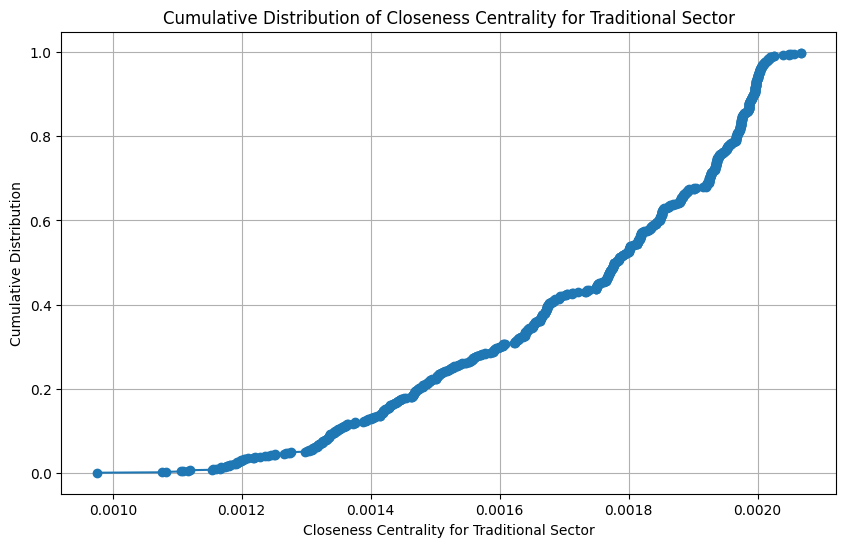

In [26]:
# Compute closeness centrality considering weights
closeness_centrality = nx.closeness_centrality(graph_final_banks, distance='weight')
closeness_centrality = {node: centrality / (len(graph_final_banks) - 1)
                        for node, centrality in closeness_centrality.items()}
    
# Get the node with the highest closeness centrality
most_central_node = max(closeness_centrality, key=closeness_centrality.get)
max_centrality = closeness_centrality[most_central_node]

print(f"Most Central Node: {most_central_node} with a Closeness Centrality of {max_centrality:.4f}")

# Plot the cumulative distribution using a log-log scale
def plot_cumulative_distribution(centrality_values, title, scale_type='loglog'):
    sorted_values = np.sort(list(centrality_values.values()))
    y_vals = np.arange(len(sorted_values)) / float(len(sorted_values))
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_values, y_vals, marker='o')
    if scale_type == 'loglog':
        plt.xscale('log')
        plt.yscale('log')
    elif scale_type == 'log':
        plt.xscale('log')
    plt.title(f'Cumulative Distribution of {title}')
    plt.xlabel(title)
    plt.ylabel('Cumulative Distribution')
    plt.grid(True)
    plt.show()

plot_cumulative_distribution(closeness_centrality, 'Closeness Centrality for Traditional Sector', 'linear')

Contagion process:
- make sure that mu and alpha sum up at most to 1
- make sure that mu and nu sum up at most to 1

In [7]:
# Scenario 1

# Step 1: Define the Reconnection Policies
class ReconnectionPolicy(Enum):
    NONE = 0
    RANDOM = 1
    RISK_AWARE = 2  

# Step 2: Define the Complete SecNet Class
class SecNet:
    def __init__(self, graph: nx.DiGraph, mu: float, beta: float, alpha: float, nu: float, stochastic: bool = True,
                 reconnection_policy: ReconnectionPolicy = ReconnectionPolicy.NONE):
        self.graph = graph.copy()
        self.mu = mu
        self.beta = beta
        self.alpha = alpha
        self.nu = nu
        self.stochastic = stochastic
        self.reconnection_policy = reconnection_policy
        self.defaulted_density = []
        self.iteration = 0
        self.removal_threshold = 15  # Threshold for removal of second-degree infected nodes
        self.birth_rate = 2  # Number of new nodes to be added in each iteration
        self.failed_counts = []
        self.S_counts = []
        self.I1_counts = []
        self.I2_counts = []
        
        for node in self.graph.nodes:
            self.graph.nodes[node]['state'] = 'S'  # Start as Susceptible
            self.graph.nodes[node]['defaulted_consecutive_turns'] = 0
    
    
    def iterate(self, verbose=True, visualize=True, plot_interval=5):
       """Perform one iteration of contagion spread."""
       nodes_to_remove = []
       self.print_node_states()
       self.S_counts.append(len([n for n in self.graph.nodes if self.graph.nodes[n]["state"] == "S"]))
       self.I1_counts.append(len([n for n in self.graph.nodes if self.graph.nodes[n]["state"] == "I1"]))
       self.I2_counts.append(len([n for n in self.graph.nodes if self.graph.nodes[n]["state"] == "I2"]))


       for node in list(self.graph.nodes):
           
           
           if 'state' not in self.graph.nodes[node]:
                print(f"Warning: assigning default state 'S' to node {node}")
                self.graph.nodes[node]['state'] = 'S'
                self.graph.nodes[node]['defaulted_consecutive_turns'] = 0

           state = self.graph.nodes[node]['state']
           neighbors = list(self.graph.neighbors(node))


           if state == 'S':  # Susceptible
               q_i = 1
               rand_val = np.random.rand()  # Generate a random number in [0,1]
               for n in neighbors:
                   if 'state' in self.graph.nodes[n] and self.graph.nodes[n]['state'] in ['I1', 'I2']:
                       if self.graph.has_edge(n, node):  # Ensure the edge exists before accessing it
                           edge_weight = self.graph[n][node].get('weight', 1)  # Get edge weight, default to 1 if missing
                           q_i *= (1 - self.beta * edge_weight)  # Multiply independent probabilities of not getting infected               
               infection_prob = 1 - q_i  # Probability that at least one neighbor infects the node
               if rand_val < infection_prob:  # Stochastic infection check
                   self.graph.nodes[node]['state'] = 'I1'


           elif state == 'I1':  # First-degree infected
               self.graph.nodes[node]['defaulted_consecutive_turns'] += 1
               rand_val = np.random.rand()  # Generate a random number in [0,1]
               if rand_val < self.alpha:  # Escalation to I2
                   self.graph.nodes[node]['state'] = 'I2'
                   self.graph.nodes[node]['defaulted_consecutive_turns'] += 1
               elif rand_val < self.alpha + self.mu:  # Recovery to S
                   self.graph.nodes[node]['state'] = 'S'
                   self.graph.nodes[node]['defaulted_consecutive_turns'] = 0
                ## else: default to I1

           elif state == 'I2':  # Second-degree infected
               self.graph.nodes[node]['defaulted_consecutive_turns'] += 1
               rand_val = np.random.rand()  # Generate a random number in [0,1]
               if rand_val < self.nu:  # Escalation to Removed 
                   nodes_to_remove.append(node)
               elif rand_val < self.nu + self.mu:  # Recovery to S
                   self.graph.nodes[node]['state'] = 'S'
                   self.graph.nodes[node]['defaulted_consecutive_turns'] = 0
               elif self.graph.nodes[node]['defaulted_consecutive_turns'] >= self.removal_threshold:
                   nodes_to_remove.append(node)

       for node in nodes_to_remove:
           if verbose:
               print(f"Removing node {node}")
           self.graph.remove_node(node)
           self.rewire_neighbors(node)

       self.failed_counts.append(len(nodes_to_remove) / (len(self.graph.nodes) + len(nodes_to_remove)))
       self.add_new_nodes()
       self.iteration += 1
       model.history = {
            "S": model.S_counts,
            "I1": model.I1_counts,
            "I2": model.I2_counts
        }

       

    def rewire_neighbors(self, removed_node):
        """Rewire neighbors of a removed node based on the reconnection policy."""
        if removed_node not in self.graph:
            return

        successors = list(self.graph.successors(removed_node))
        self.graph.remove_node(removed_node)

        if self.reconnection_policy == ReconnectionPolicy.RANDOM:
            for nbr in successors:
                if len(self.graph.nodes) > 0:
                    nodes = list(self.graph.nodes)
                    new_target = random.choice(nodes)
                    self.graph.add_edge(nbr, new_target)

        elif self.reconnection_policy == ReconnectionPolicy.RISK_AWARE:
            for nbr in successors:
                # only reconnect to currently‐healthy nodes
                candidates = [n for n in self.graph.nodes if self.graph.nodes[n]['state']=='S']
                if candidates:
                    new_target = random.choice(candidates)
                    self.graph.add_edge(nbr, new_target)

    def add_new_nodes(self):
        for i in range(self.birth_rate):
            new_node_id = f"birth_{self.iteration}_{i}"
            self.graph.add_node(new_node_id)
            self.graph.nodes[new_node_id]['state'] = 'S'
            self.graph.nodes[new_node_id]['defaulted_consecutive_turns'] = 0

            # only pick a target if there's at least one other node
            if len(self.graph.nodes) > 1:
                nodes = list(self.graph.nodes)       
                target = random.choice(nodes)        
                self.graph.add_edge(new_node_id, target)

    def print_node_states(self):
        """Prints the states of all nodes in the network."""
        print(f"\nIteration {self.iteration + 1} - Node States:")
        # Initialize counters for each state
        state_counts = {"S": 0, "I1": 0, "I2": 0}
        for node in self.graph.nodes:
            node_state = self.graph.nodes[node].get("state", "Unknown")
            print(f"Node {node}: {self.graph.nodes[node].get('state', 'Missing')}")
            # Update count for the state if valid
            if node_state in state_counts:
                state_counts[node_state] += 1
        print("\nState Counts:")
        for state, count in state_counts.items():
            print(f"{state}: {count}")

    def plot_graph(self):
        """Plots the network with color-coded states."""
        pos = nx.spring_layout(self.graph, seed=42)
        colors = {'S': 'blue', 'I1': 'orange', 'I2': 'red'}
        node_colors = [
            colors.get(self.graph.nodes[n].get('state', 'S'), 'gray') 
            for n in self.graph.nodes
        ]

        plt.figure(figsize=(8, 6))
        nx.draw(self.graph, pos, node_color=node_colors, with_labels=True, edge_color='gray')
        plt.title(f"Contagion Spread - Iteration {self.iteration}")
        plt.show()



model = SecNet(
    graph=graph_final_banks,  
    mu=0.03,    # Recovery rate (I1 -> S)
    beta=0.7,  # Infection rate (S -> I1)
    alpha=0.3, # Escalation rate (I1 -> I2)
    nu=0.07,    # Removal rate (I2 -> Rm)
    stochastic=True,  # Enable stochastic transitions
    reconnection_policy=ReconnectionPolicy.NONE  # Use random reconnection
)

# Initial Infections
num_nodes = len(graph_final_banks.nodes)
initial_infected_count = int(0.25 * num_nodes)
initial_infected = np.random.choice(list(graph_final_banks.nodes), size=initial_infected_count, replace=False)
for node in initial_infected:
    model.graph.nodes[node]['state'] = 'I1'  # Infect initial nodes

# Set a tolerance: percentage of nodes allowed to still change
tolerance = 0.001  # 1% of nodes can still change without stopping
max_iterations = 1000  # Prevent infinite loops

# Initialize previous state
previous_states = {node: model.graph.nodes[node]['state'] for node in model.graph.nodes}
total_nodes = len(previous_states)

for t in range(max_iterations):
    model.iterate(verbose=True, visualize=True, plot_interval=5)
    # Check current states
    current_states = {
        node: data['state']
        for node, data in model.graph.nodes(data=True)
        if 'state' in data
    }
    # Count number of nodes whose state has changed
    changes = sum(
        1 for node in current_states
        if node in previous_states and previous_states[node] != current_states[node]
    )
    # If changes are below tolerance, stop
    if changes / total_nodes <= tolerance:
        print(f"Equilibrium (within tolerance) reached at iteration {t+1}")
        break
    # Update previous states
    previous_states = current_states





Iteration 1 - Node States:
Node 0: S
Node 1: S
Node 2: S
Node 4: S
Node 6: S
Node 8: S
Node 9: S
Node 13: S
Node 14: S
Node 16: S
Node 34: I1
Node 35: S
Node 36: S
Node 46: I1
Node 52: S
Node 67: S
Node 72: S
Node 75: S
Node 78: I1
Node 80: S
Node 81: I1
Node 82: I1
Node 88: S
Node 96: S
Node 112: S
Node 119: S
Node 140: S
Node 148: I1
Node 149: S
Node 151: S
Node 154: S
Node 188: S
Node 195: I1
Node 204: I1
Node 206: S
Node 209: I1
Node 256: S
Node 257: S
Node 263: S
Node 265: S
Node 273: S
Node 284: S
Node 303: S
Node 375: S
Node 387: S
Node 392: I1
Node 395: S
Node 400: S
Node 450: S
Node 577: S
Node 606: S
Node 607: S
Node 623: S
Node 698: I1
Node 744: S
Node 759: S
Node 804: S
Node 861: I1
Node 870: I1
Node 878: S
Node 889: S
Node 907: S
Node 963: S
Node 988: I1
Node 3: S
Node 840: S
Node 5: S
Node 7: S
Node 10: S
Node 11: S
Node 12: S
Node 17: I1
Node 18: S
Node 21: I1
Node 22: I1
Node 24: S
Node 25: S
Node 30: S
Node 37: S
Node 41: S
Node 44: S
Node 54: S
Node 56: S
Node 57: S


I1 = 10 circa
I2 = 30
S = 46

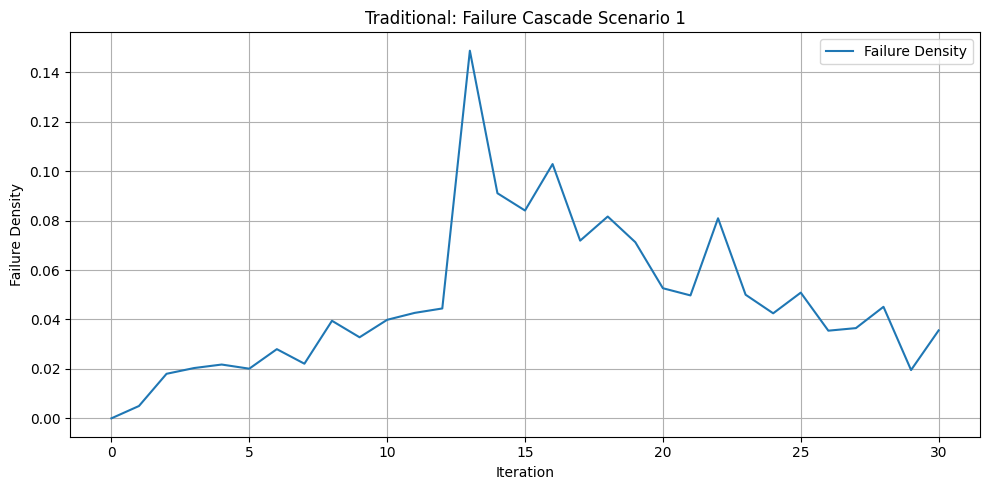

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(model.failed_counts, label="Failure Density")
plt.xlabel("Iteration")
plt.ylabel("Failure Density")
plt.title("Traditional: Failure Cascade Scenario 1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
degrees = [deg for _, deg in model.graph.degree()]
average_degree = np.mean(degrees)

print(f"Average degree of the final network: {average_degree:.2f}")

Average degree of the final network: 0.63


In [9]:
total_N = model.graph.number_of_nodes()
print("Total population (N):", total_N)

Total population (N): 246


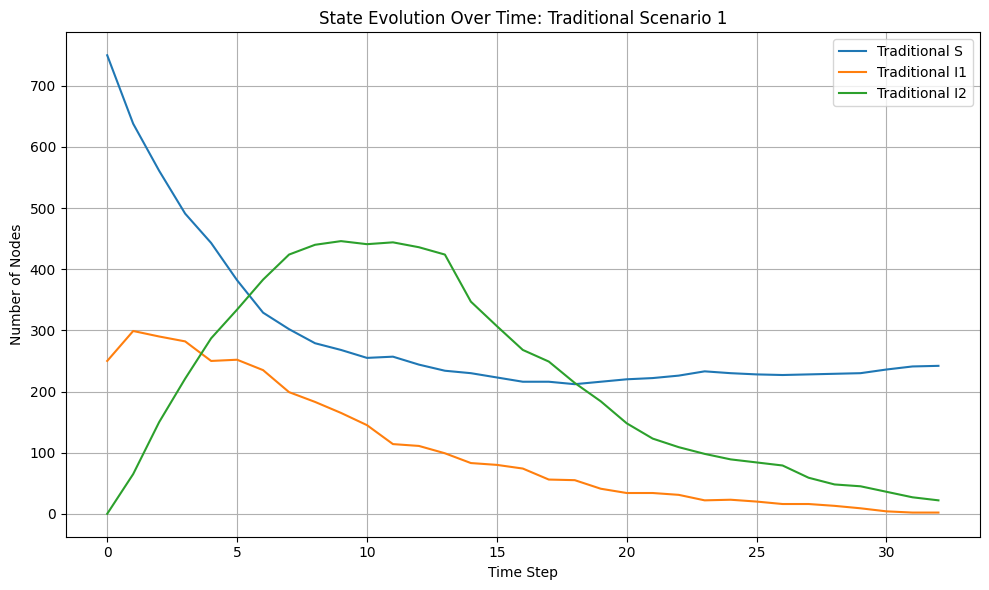

In [113]:
def plot_state_evolution(history, label_prefix=""):
    steps = range(len(history["S"]))
    plt.plot(steps, history["S"], label=f"{label_prefix} S")
    plt.plot(steps, history["I1"], label=f"{label_prefix} I1")
    plt.plot(steps, history["I2"], label=f"{label_prefix} I2")

plt.figure(figsize=(10, 6))
plot_state_evolution(model.history, label_prefix="Traditional")
plt.xlabel("Time Step")
plt.ylabel("Number of Nodes")
plt.title("State Evolution Over Time: Traditional Scenario 1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Scenario 2

# Step 1: Define the Reconnection Policies
class ReconnectionPolicy(Enum):
    NONE = 0
    RANDOM = 1
    RISK_AWARE = 2  

# Step 2: Define the Complete SecNet Class
class SecNet:
    def __init__(self, graph: nx.DiGraph, mu: float, beta: float, alpha: float, nu: float, stochastic: bool = True,
                 reconnection_policy: ReconnectionPolicy = ReconnectionPolicy.RISK_AWARE):
        self.graph = graph.copy()
        self.mu = mu
        self.beta = beta
        self.alpha = alpha
        self.nu = nu
        self.stochastic = stochastic
        self.reconnection_policy = reconnection_policy
        self.defaulted_density = []
        self.iteration = 0
        self.removal_threshold = 15  # Threshold for removal of second-degree infected nodes
        self.birth_rate = 2  # Number of new nodes to be added in each iteration
        self.failed_counts = []
        self.S_counts = []
        self.I1_counts = []
        self.I2_counts = []
        
        for node in self.graph.nodes:
            self.graph.nodes[node]['state'] = 'S'  # Start as Susceptible
            self.graph.nodes[node]['defaulted_consecutive_turns'] = 0
    
    
    def iterate(self, verbose=True, visualize=True, plot_interval=5):
       """Perform one iteration of contagion spread."""
       nodes_to_remove = []
       self.print_node_states()
       self.S_counts.append(len([n for n in self.graph.nodes if self.graph.nodes[n]["state"] == "S"]))
       self.I1_counts.append(len([n for n in self.graph.nodes if self.graph.nodes[n]["state"] == "I1"]))
       self.I2_counts.append(len([n for n in self.graph.nodes if self.graph.nodes[n]["state"] == "I2"]))

       for node in list(self.graph.nodes):

           if 'state' not in self.graph.nodes[node]:
                print(f"Warning: assigning default state 'S' to node {node}")
                self.graph.nodes[node]['state'] = 'S'
                self.graph.nodes[node]['defaulted_consecutive_turns'] = 0

           state = self.graph.nodes[node]['state']
           neighbors = list(self.graph.neighbors(node))


           if state == 'S':  # Susceptible
               q_i = 1
               rand_val = np.random.rand()  # Generate a random number in [0,1]
               for n in neighbors:
                   if 'state' in self.graph.nodes[n] and self.graph.nodes[n]['state'] in ['I1', 'I2']:
                       if self.graph.has_edge(n, node):  # Ensure the edge exists before accessing it
                           edge_weight = self.graph[n][node].get('weight', 1)  # Get edge weight, default to 1 if missing
                           q_i *= (1 - self.beta * edge_weight)  # Multiply independent probabilities of not getting infected               
               infection_prob = 1 - q_i  # Probability that at least one neighbor infects the node
               if rand_val < infection_prob:  # Stochastic infection check
                   self.graph.nodes[node]['state'] = 'I1'


           elif state == 'I1':  # First-degree infected
               self.graph.nodes[node]['defaulted_consecutive_turns'] += 1
               rand_val = np.random.rand()  # Generate a random number in [0,1]
               if rand_val < self.alpha:  # Escalation to I2
                   self.graph.nodes[node]['state'] = 'I2'
                   self.graph.nodes[node]['defaulted_consecutive_turns'] += 1
               elif rand_val < self.alpha + self.mu:  # Recovery to S
                   self.graph.nodes[node]['state'] = 'S'
                   self.graph.nodes[node]['defaulted_consecutive_turns'] = 0
                ## else: default to I1

           elif state == 'I2':  # Second-degree infected
               self.graph.nodes[node]['defaulted_consecutive_turns'] += 1
               rand_val = np.random.rand()  # Generate a random number in [0,1]
               if rand_val < self.nu:  # Escalation to Removed 
                   nodes_to_remove.append(node)
               elif rand_val < self.nu + self.mu:  # Recovery to S
                   self.graph.nodes[node]['state'] = 'S'
                   self.graph.nodes[node]['defaulted_consecutive_turns'] = 0
               elif self.graph.nodes[node]['defaulted_consecutive_turns'] >= self.removal_threshold:
                   nodes_to_remove.append(node)

       for node in nodes_to_remove:
           if verbose:
               print(f"Removing node {node}")
           self.graph.remove_node(node)
           self.rewire_neighbors(node)

       self.failed_counts.append(len(nodes_to_remove) / (len(self.graph.nodes) + len(nodes_to_remove)))
       self.add_new_nodes()
       self.iteration += 1
       model.history2 = {
            "S": model.S_counts,
            "I1": model.I1_counts,
            "I2": model.I2_counts
        }

       

    def rewire_neighbors(self, removed_node):
        """Rewire neighbors of a removed node based on the reconnection policy."""
        if removed_node not in self.graph:
            return

        successors = list(self.graph.successors(removed_node))
        self.graph.remove_node(removed_node)

        if self.reconnection_policy == ReconnectionPolicy.RANDOM:
            for nbr in successors:
                if len(self.graph.nodes) > 0:
                    nodes = list(self.graph.nodes)
                    new_target = random.choice(nodes)
                    self.graph.add_edge(nbr, new_target)

        elif self.reconnection_policy == ReconnectionPolicy.RISK_AWARE:
            for nbr in successors:
                # only reconnect to currently‐healthy nodes
                candidates = [n for n in self.graph.nodes if self.graph.nodes[n]['state']=='S']
                if candidates:
                    new_target = random.choice(candidates)
                    self.graph.add_edge(nbr, new_target)

    def add_new_nodes(self):
        for i in range(self.birth_rate):
            new_node_id = f"birth_{self.iteration}_{i}"
            self.graph.add_node(new_node_id)
            self.graph.nodes[new_node_id]['state'] = 'S'
            self.graph.nodes[new_node_id]['defaulted_consecutive_turns'] = 0

            # only pick a target if there's at least one other node
            if len(self.graph.nodes) > 1:
                nodes = list(self.graph.nodes)       # snapshot of current node keys
                target = random.choice(nodes)        # pure-Python choice, preserves types
                self.graph.add_edge(new_node_id, target)

    def print_node_states(self):
        """Prints the states of all nodes in the network."""
        print(f"\nIteration {self.iteration + 1} - Node States:")
        # Initialize counters for each state
        state_counts = {"S": 0, "I1": 0, "I2": 0}
        for node in self.graph.nodes:
            node_state = self.graph.nodes[node].get("state", "Unknown")
            print(f"Node {node}: {self.graph.nodes[node].get('state', 'Missing')}")
            # Update count for the state if valid
            if node_state in state_counts:
                state_counts[node_state] += 1
        print("\nState Counts:")
        for state, count in state_counts.items():
            print(f"{state}: {count}")

    def plot_graph(self):
        """Plots the network with color-coded states."""
        pos = nx.spring_layout(self.graph, seed=42)
        colors = {'S': 'blue', 'I1': 'orange', 'I2': 'red'}
        node_colors = [
            colors.get(self.graph.nodes[n].get('state', 'S'), 'gray') 
            for n in self.graph.nodes
        ]

        plt.figure(figsize=(8, 6))
        nx.draw(self.graph, pos, node_color=node_colors, with_labels=True, edge_color='gray')
        plt.title(f"Contagion Spread - Iteration {self.iteration}")
        plt.show()



model = SecNet(
    graph=graph_final_banks,  
    mu=0.03,    # Recovery rate (I1 -> S)
    beta=0.7,  # Infection rate (S -> I1)
    alpha=0.3, # Escalation rate (I1 -> I2)
    nu=0.07,    # Removal rate (I2 -> Rm)
    stochastic=True,  # Enable stochastic transitions
    reconnection_policy=ReconnectionPolicy.RISK_AWARE  # Use random reconnection
)

# Initial Infections
num_nodes = len(graph_final_banks.nodes)
initial_infected_count = int(0.25 * num_nodes)
initial_infected = np.random.choice(list(graph_final_banks.nodes), size=initial_infected_count, replace=False)
for node in initial_infected:
    model.graph.nodes[node]['state'] = 'I1'  # Infect initial nodes

# Set a tolerance: percentage of nodes allowed to still change
tolerance = 0.001  # 1% of nodes can still change without stopping
max_iterations = 1000  # Prevent infinite loops

# Initialize previous state
previous_states = {node: model.graph.nodes[node]['state'] for node in model.graph.nodes}
total_nodes = len(previous_states)

for t in range(max_iterations):
    model.iterate(verbose=True, visualize=True, plot_interval=5)
    # Check current states
    current_states = {
        node: data['state']
        for node, data in model.graph.nodes(data=True)
        if 'state' in data
    }
    # Count number of nodes whose state has changed
    changes = sum(
        1 for node in current_states
        if node in previous_states and previous_states[node] != current_states[node]
    )
    # If changes are below tolerance, stop
    if changes / total_nodes <= tolerance:
        print(f"Equilibrium (within tolerance) reached at iteration {t+1}")
        break
    # Update previous states
    previous_states = current_states





Iteration 1 - Node States:
Node 0: I1
Node 1: I1
Node 2: S
Node 4: S
Node 6: S
Node 8: I1
Node 9: I1
Node 13: S
Node 14: S
Node 16: S
Node 34: S
Node 35: S
Node 36: S
Node 46: S
Node 52: I1
Node 67: S
Node 72: S
Node 75: I1
Node 78: I1
Node 80: S
Node 81: S
Node 82: S
Node 88: S
Node 96: S
Node 112: S
Node 119: S
Node 140: S
Node 148: I1
Node 149: I1
Node 151: S
Node 154: S
Node 188: S
Node 195: S
Node 204: S
Node 206: S
Node 209: S
Node 256: S
Node 257: I1
Node 263: I1
Node 265: I1
Node 273: S
Node 284: S
Node 303: S
Node 375: S
Node 387: I1
Node 392: I1
Node 395: S
Node 400: S
Node 450: S
Node 577: S
Node 606: S
Node 607: S
Node 623: S
Node 698: S
Node 744: S
Node 759: S
Node 804: S
Node 861: I1
Node 870: S
Node 878: I1
Node 889: S
Node 907: S
Node 963: S
Node 988: S
Node 3: S
Node 840: S
Node 5: S
Node 7: S
Node 10: I1
Node 11: S
Node 12: S
Node 17: I1
Node 18: S
Node 21: S
Node 22: I1
Node 24: I1
Node 25: S
Node 30: S
Node 37: S
Node 41: S
Node 44: S
Node 54: I1
Node 56: S
Node 57

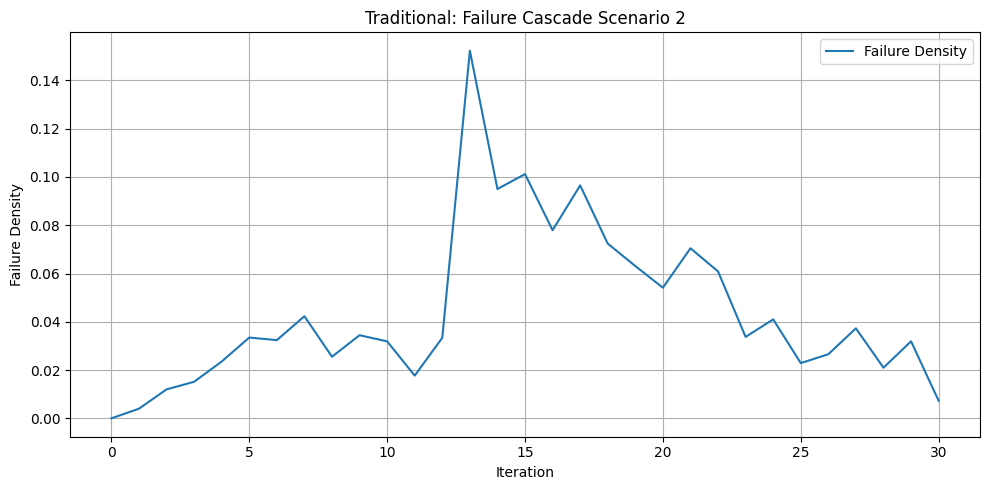

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(model.failed_counts, label="Failure Density")
plt.xlabel("Iteration")
plt.ylabel("Failure Density")
plt.title("Traditional: Failure Cascade Scenario 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

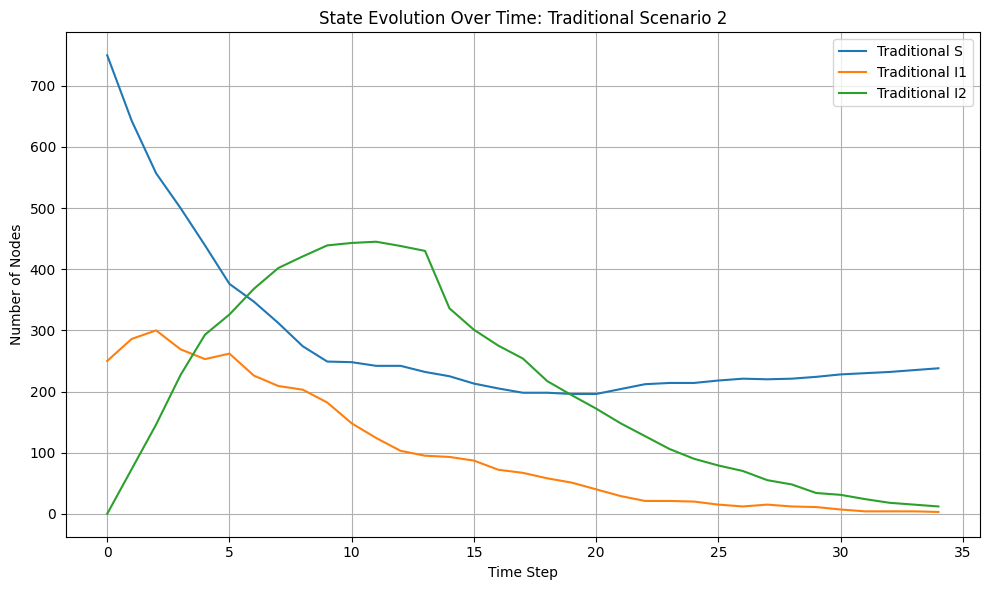

In [17]:
def plot_state_evolution(history2, label_prefix=""):
    steps = range(len(history2["S"]))
    plt.plot(steps, history2["S"], label=f"{label_prefix} S")
    plt.plot(steps, history2["I1"], label=f"{label_prefix} I1")
    plt.plot(steps, history2["I2"], label=f"{label_prefix} I2")

plt.figure(figsize=(10, 6))
plot_state_evolution(model.history2, label_prefix="Traditional")
plt.xlabel("Time Step")
plt.ylabel("Number of Nodes")
plt.title("State Evolution Over Time: Traditional Scenario 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# Scenario 3

# Step 1: Define the Reconnection Policies
class ReconnectionPolicy(Enum):
    NONE = 0
    RANDOM = 1
    RISK_AWARE = 2  

# Step 2: Define the Complete SecNet Class
class SecNet:
    def __init__(self, graph: nx.DiGraph, mu: float, beta: float, alpha: float, nu: float, stochastic: bool = True,
                 reconnection_policy: ReconnectionPolicy = ReconnectionPolicy.RISK_AWARE):
        self.graph = graph.copy()
        self.mu = mu
        self.beta = beta
        self.alpha = alpha
        self.nu = nu
        self.stochastic = stochastic
        self.reconnection_policy = reconnection_policy
        self.defaulted_density = []
        self.iteration = 0
        self.removal_threshold = 15  # Threshold for removal of second-degree infected nodes
        self.birth_rate = 2  # Number of new nodes to be added in each iteration
        self.failed_counts = []
        self.S_counts = []
        self.I1_counts = []
        self.I2_counts = []
        num_tbtf = max(1, int(0.1 * len(self.graph.nodes)))
        top_degree_nodes = sorted(self.graph.degree, key=lambda x: x[1], reverse=True)[:num_tbtf]
        for node, _ in top_degree_nodes:
            self.graph.nodes[node]['too_big_to_fail'] = True
        
        for node in self.graph.nodes:
            self.graph.nodes[node]['state'] = 'S'  # Start as Susceptible
            self.graph.nodes[node]['defaulted_consecutive_turns'] = 0
    
    
    def iterate(self, verbose=True, visualize=True, plot_interval=5):
       """Perform one iteration of contagion spread."""
       nodes_to_remove = []
       self.print_node_states()
       self.S_counts.append(len([n for n in self.graph.nodes if self.graph.nodes[n]["state"] == "S"]))
       self.I1_counts.append(len([n for n in self.graph.nodes if self.graph.nodes[n]["state"] == "I1"]))
       self.I2_counts.append(len([n for n in self.graph.nodes if self.graph.nodes[n]["state"] == "I2"]))

       for node in list(self.graph.nodes):

           if 'state' not in self.graph.nodes[node]:
                print(f"Warning: assigning default state 'S' to node {node}")
                self.graph.nodes[node]['state'] = 'S'
                self.graph.nodes[node]['defaulted_consecutive_turns'] = 0

           state = self.graph.nodes[node]['state']
           neighbors = list(self.graph.neighbors(node))


           if state == 'S':  # Susceptible
               q_i = 1
               rand_val = np.random.rand()  # Generate a random number in [0,1]
               for n in neighbors:
                   if 'state' in self.graph.nodes[n] and self.graph.nodes[n]['state'] in ['I1', 'I2']:
                       if self.graph.has_edge(n, node):  # Ensure the edge exists before accessing it
                           edge_weight = self.graph[n][node].get('weight', 1)  # Get edge weight, default to 1 if missing
                           q_i *= (1 - self.beta * edge_weight)  # Multiply independent probabilities of not getting infected               
               infection_prob = 1 - q_i  # Probability that at least one neighbor infects the node
               if rand_val < infection_prob:  # Stochastic infection check
                   self.graph.nodes[node]['state'] = 'I1'


           elif state == 'I1':  # First-degree infected
               self.graph.nodes[node]['defaulted_consecutive_turns'] += 1
               rand_val = np.random.rand()  # Generate a random number in [0,1]
               if rand_val < self.alpha:  # Escalation to I2
                   self.graph.nodes[node]['state'] = 'I2'
                   self.graph.nodes[node]['defaulted_consecutive_turns'] += 1
               elif rand_val < self.alpha + self.mu:  # Recovery to S
                   self.graph.nodes[node]['state'] = 'S'
                   self.graph.nodes[node]['defaulted_consecutive_turns'] = 0
                ## else: default to I1

           elif state == 'I2':  # Second-degree infected
               self.graph.nodes[node]['defaulted_consecutive_turns'] += 1
               rand_val = np.random.rand()  # Generate a random number in [0,1]
               if rand_val < self.nu:
                if self.graph.nodes[node].get('too_big_to_fail', False):
                    self.graph.nodes[node]['state'] = 'S'  # TBTF bailout
                    self.graph.nodes[node]['defaulted_consecutive_turns'] = 0
                else:
                    nodes_to_remove.append(node)
               elif rand_val < self.nu + self.mu:  # Recovery to S
                   self.graph.nodes[node]['state'] = 'S'
                   self.graph.nodes[node]['defaulted_consecutive_turns'] = 0
               elif self.graph.nodes[node]['defaulted_consecutive_turns'] >= self.removal_threshold:
                if self.graph.nodes[node].get('too_big_to_fail', False):
                    self.graph.nodes[node]['state'] = 'S'
                    self.graph.nodes[node]['defaulted_consecutive_turns'] = 0
                else:
                    nodes_to_remove.append(node)
       for node in nodes_to_remove:
           if verbose:
               print(f"Removing node {node}")
           self.graph.remove_node(node)
           self.rewire_neighbors(node)

       self.failed_counts.append(len(nodes_to_remove) / (len(self.graph.nodes) + len(nodes_to_remove)))
       self.add_new_nodes()
       self.iteration += 1
       model.history3 = {
            "S": model.S_counts,
            "I1": model.I1_counts,
            "I2": model.I2_counts
        }

       

    def rewire_neighbors(self, removed_node):
        """Rewire neighbors of a removed node based on the reconnection policy."""
        if removed_node not in self.graph:
            return

        successors = list(self.graph.successors(removed_node))
        self.graph.remove_node(removed_node)

        if self.reconnection_policy == ReconnectionPolicy.RANDOM:
            for nbr in successors:
                if len(self.graph.nodes) > 0:
                    nodes = list(self.graph.nodes)
                    new_target = random.choice(nodes)
                    self.graph.add_edge(nbr, new_target)

        elif self.reconnection_policy == ReconnectionPolicy.RISK_AWARE:
            for nbr in successors:
                # only reconnect to currently‐healthy nodes
                candidates = [n for n in self.graph.nodes if self.graph.nodes[n]['state']=='S']
                if candidates:
                    new_target = random.choice(candidates)
                    self.graph.add_edge(nbr, new_target)

    def add_new_nodes(self):
        for i in range(self.birth_rate):
            new_node_id = f"birth_{self.iteration}_{i}"
            self.graph.add_node(new_node_id)
            self.graph.nodes[new_node_id]['state'] = 'S'
            self.graph.nodes[new_node_id]['defaulted_consecutive_turns'] = 0

            # only pick a target if there's at least one other node
            if len(self.graph.nodes) > 1:
                nodes = list(self.graph.nodes)       # snapshot of current node keys
                target = random.choice(nodes)        # pure-Python choice, preserves types
                self.graph.add_edge(new_node_id, target)

    def print_node_states(self):
        """Prints the states of all nodes in the network."""
        print(f"\nIteration {self.iteration + 1} - Node States:")
        # Initialize counters for each state
        state_counts = {"S": 0, "I1": 0, "I2": 0}
        for node in self.graph.nodes:
            node_state = self.graph.nodes[node].get("state", "Unknown")
            print(f"Node {node}: {self.graph.nodes[node].get('state', 'Missing')}")
            # Update count for the state if valid
            if node_state in state_counts:
                state_counts[node_state] += 1
        print("\nState Counts:")
        for state, count in state_counts.items():
            print(f"{state}: {count}")

    def plot_graph(self):
        """Plots the network with color-coded states."""
        pos = nx.spring_layout(self.graph, seed=42)
        colors = {'S': 'blue', 'I1': 'orange', 'I2': 'red'}
        node_colors = [
            colors.get(self.graph.nodes[n].get('state', 'S'), 'gray') 
            for n in self.graph.nodes
        ]

        plt.figure(figsize=(8, 6))
        nx.draw(self.graph, pos, node_color=node_colors, with_labels=True, edge_color='gray')
        plt.title(f"Contagion Spread - Iteration {self.iteration}")
        plt.show()



model = SecNet(
    graph=graph_final_banks,  
    mu=0.03,    # Recovery rate (I1 -> S)
    beta=0.7,  # Infection rate (S -> I1)
    alpha=0.3, # Escalation rate (I1 -> I2)
    nu=0.07,    # Removal rate (I2 -> Rm)
    stochastic=True,  # Enable stochastic transitions
    reconnection_policy=ReconnectionPolicy.RISK_AWARE  # Use random reconnection
)

# Initial Infections
num_nodes = len(graph_final_banks.nodes)
initial_infected_count = int(0.25 * num_nodes)
initial_infected = np.random.choice(list(graph_final_banks.nodes), size=initial_infected_count, replace=False)
for node in initial_infected:
    model.graph.nodes[node]['state'] = 'I1'  # Infect initial nodes

# Set a tolerance: percentage of nodes allowed to still change
tolerance = 0.001  # 1% of nodes can still change without stopping
max_iterations = 1000  # Prevent infinite loops

# Initialize previous state
previous_states = {node: model.graph.nodes[node]['state'] for node in model.graph.nodes}
total_nodes = len(previous_states)

for t in range(max_iterations):
    model.iterate(verbose=True, visualize=True, plot_interval=5)
    # Check current states
    current_states = {
        node: data['state']
        for node, data in model.graph.nodes(data=True)
        if 'state' in data
    }
    # Count number of nodes whose state has changed
    changes = sum(
        1 for node in current_states
        if node in previous_states and previous_states[node] != current_states[node]
    )
    # If changes are below tolerance, stop
    if changes / total_nodes <= tolerance:
        print(f"Equilibrium (within tolerance) reached at iteration {t+1}")
        break
    # Update previous states
    previous_states = current_states





Iteration 1 - Node States:
Node 0: S
Node 1: S
Node 2: S
Node 4: S
Node 6: S
Node 8: S
Node 9: I1
Node 13: S
Node 14: S
Node 16: S
Node 34: S
Node 35: S
Node 36: S
Node 46: S
Node 52: S
Node 67: I1
Node 72: S
Node 75: S
Node 78: I1
Node 80: S
Node 81: S
Node 82: S
Node 88: I1
Node 96: S
Node 112: I1
Node 119: S
Node 140: S
Node 148: S
Node 149: S
Node 151: S
Node 154: I1
Node 188: S
Node 195: S
Node 204: S
Node 206: S
Node 209: I1
Node 256: I1
Node 257: S
Node 263: I1
Node 265: S
Node 273: S
Node 284: I1
Node 303: S
Node 375: S
Node 387: S
Node 392: I1
Node 395: S
Node 400: S
Node 450: S
Node 577: S
Node 606: S
Node 607: S
Node 623: S
Node 698: I1
Node 744: I1
Node 759: S
Node 804: S
Node 861: S
Node 870: I1
Node 878: S
Node 889: S
Node 907: I1
Node 963: S
Node 988: I1
Node 3: I1
Node 840: S
Node 5: S
Node 7: I1
Node 10: S
Node 11: S
Node 12: S
Node 17: S
Node 18: S
Node 21: S
Node 22: S
Node 24: S
Node 25: S
Node 30: I1
Node 37: I1
Node 41: S
Node 44: I1
Node 54: S
Node 56: I1
Node 5

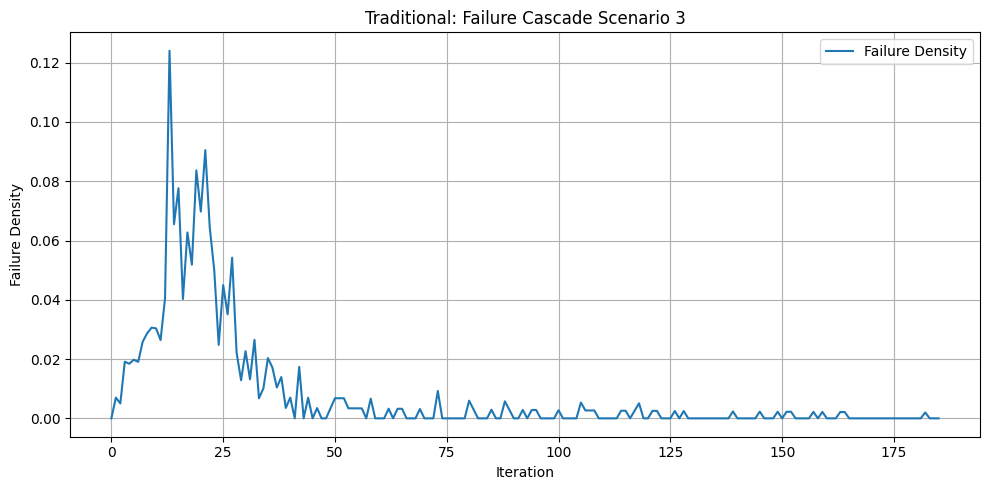

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(model.failed_counts, label="Failure Density")
plt.xlabel("Iteration")
plt.ylabel("Failure Density")
plt.title("Traditional: Failure Cascade Scenario 3")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

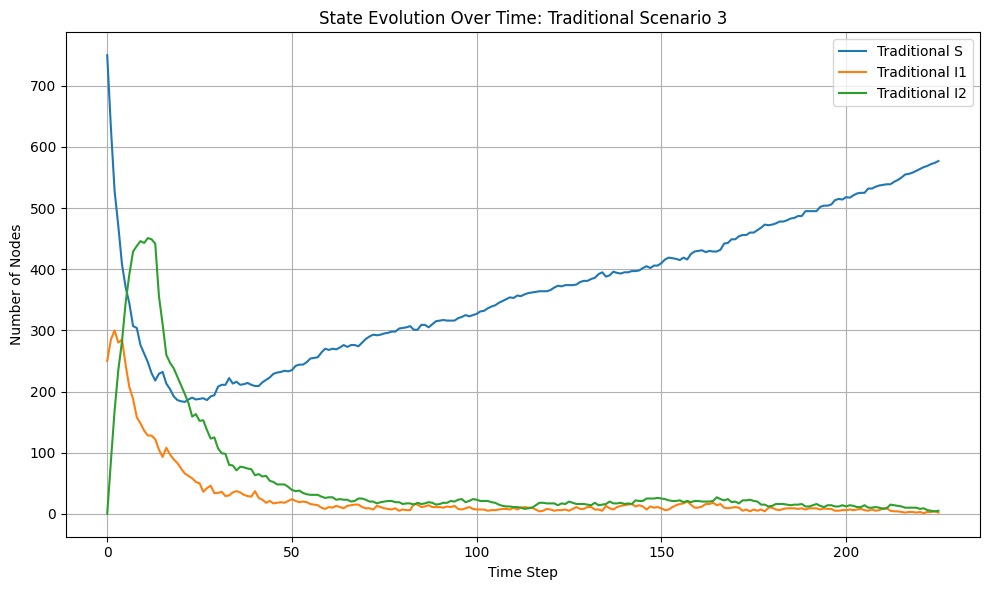

In [104]:
def plot_state_evolution(history3, label_prefix=""):
    steps = range(len(history3["S"]))
    plt.plot(steps, history3["S"], label=f"{label_prefix} S")
    plt.plot(steps, history3["I1"], label=f"{label_prefix} I1")
    plt.plot(steps, history3["I2"], label=f"{label_prefix} I2")

plt.figure(figsize=(10, 6))
plot_state_evolution(model.history3, label_prefix="Traditional")
plt.xlabel("Time Step")
plt.ylabel("Number of Nodes")
plt.title("State Evolution Over Time: Traditional Scenario 3")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()